# Data Preparation

Dataset: https://www.kaggle.com/datasets/nasa/astronaut-yearbook/data

<a href="https://github.com/simecek/dspracticum2023/blob/main/lesson08/ds_practicum_ex_astronauts_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

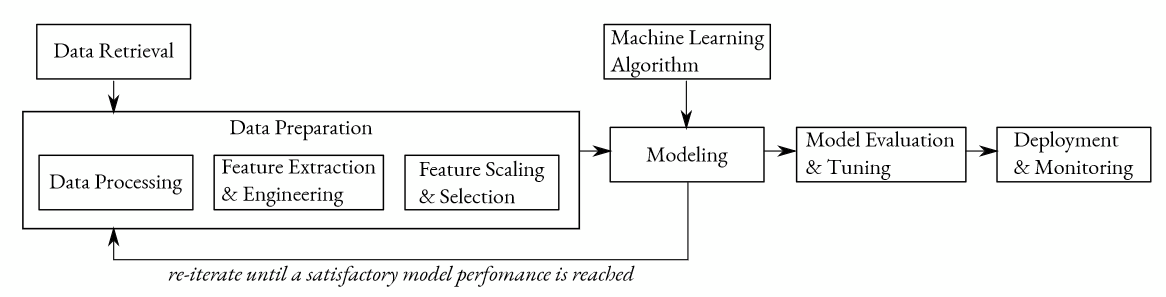

Download the dataset:

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'amllogin'
os.environ['KAGGLE_KEY'] = '35eca611ac64064016cba986e2161cdd'

!kaggle datasets download -d nasa/astronaut-yearbook -p {'.'}

astronaut-yearbook.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

dataset_path = '/content/data_preparation_exercise/'

with zipfile.ZipFile('astronaut-yearbook.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [ ]:
import pandas as pd

csv_filepath = dataset_path + 'astronauts.csv'
df = pd.read_csv(csv_filepath)
df

## 0. Data Exploration

- get insights to your dataset (you can laso look at the original dataset description at https://www.kaggle.com/datasets/nasa/astronaut-yearbook/data)


In [1]:
# TODO: get insight into your dataset, use functions as
# df.describe(), df.info()

# answer the next questions:

What is the Gender ratio?

In [ ]:
import matplotlib.pyplot as plt

# TODO: count distinct values of values in the 'Gender' column and display the result (e.g. as a pie chart)

Plot histogram of values of one feature (1 column):

In [ ]:
import seaborn as sns

# TODO
# hint: use sns.histplot()

Was somebody on more than one `Mission`s?

(hint: Missions would be separated by a comma.)

In [ ]:
# TODO: parse the information in 'Mission' column and count the number of missions, then filter based on that number

How many astronauts died on a mission?

In [ ]:
# TODO

How the total number of `Space Flights` (especially for Males vs Females) have evolved over the years.

In [ ]:
# TODO: plot line charts of 'Space Flights' count throughout the 'Year', colour by 'Gender'

How many astronauts were on a mission in a different century than the one they were born in?

In [3]:
# TODO: use the 'Year' and 'Birth Date' columns

## 1. Data Cleaning

Look for duplicites:

In [ ]:
df.loc[df.duplicated()]

,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,Military Rank,Military Branch,Space Flights,Space Flight (hr),Space Walks,Space Walks (hr),Missions,Death Date,Death Mission,Missions Count


We can also look for duplicites only w.r.t. to one feature and not the entire sample (row):

In [ ]:
df.loc[df.duplicated(['Birth Date'])]

,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,Military Rank,Military Branch,Space Flights,Space Flight (hr),Space Walks,Space Walks (hr),Missions,Death Date,Death Mission,Missions Count
125,Charles D. Gemar,1985.0,11.0,Retired,8/4/1955,"Yanktown, SD",Male,US Military Academy,Engineering,NaN,Lieutenant Colonel,US Army,3,581,0,0.0,"STS-38 (Atlantis), STS-48 (Discovery), STS-62 ...",NaN,NaN,3
183,Scott J. Kelly,1996.0,16.0,Active,2/21/1964,"Orange, NJ",Male,State University of New York Maritime College;...,Electrical Engineering,Aviation Systems,Captain,US Navy (Retired),4,12490,3,18.0,"STS-103 (Discovery), STS-118 (Endeavor), ISS-2...",NaN,NaN,4
238,Steven R. Nagel,1978.0,8.0,Retired,10/27/1946,"Canton, IL",Male,University of Illinois; California State Unive...,Aerospace Engineering,Mechanical Engineering,Colonel,US Air Force (Retired),4,721,0,0.0,"STS 51-G (Discovery), STS 61-A (Challenger), S...",NaN,NaN,4
262,John L. Phillips,1996.0,16.0,Retired,4/15/1951,"Ft. Belvoir, VA",Male,US Naval Academy; University of West Florida; ...,Mathematics; Russian,Aeronautical Systems; Geophysics & Space Physics,Captain,US Naval Reserves (Retired),3,4880,1,5.0,"STS-100 (Endeavor), ISS-11 (Soyuz), STS-119 (D...",NaN,NaN,3
264,Alan G. Poindexter,1998.0,17.0,Deceased,11/5/1961,"Pasadena, CA",Male,Georgia Institute of Technology; US Naval Post...,Aerospace Engineering,Aeronautical Engineering,Captain,US Navy,2,669,0,0.0,"STS-122 (Atlantis), STS-131 (Discovery)",7/1/2012,NaN,2
303,Sherwood C. Spring,1980.0,9.0,Retired,9/23/1944,"Hartford, CT",Male,US Military Academy; University of Arizona,Engineering,Aerospace Engineering,Colonel,US Army (Retired),1,165,2,12.0,STS 61-B (Atlantis),NaN,NaN,1
305,Thomas P. Stafford,1962.0,2.0,Retired,9/17/1930,"Weatherford, OK",Male,US Naval Academy,NaN,NaN,Lieutenant General,US Air Force (Retired),4,507,0,0.0,"Gemini 6, Gemini 9, Apollo 10, Apollo-Soyuz Te...",NaN,NaN,4
319,Kathryn C. Thornton,1984.0,10.0,Retired,8/17/1952,"Montgomery, AL",Female,Auburn University; University of Virginia,Physics,Physics,NaN,NaN,4,975,3,21.0,"STS-33 (Discovery), STS-49 (Endeavor), STS-61 ...",NaN,NaN,4
329,James S. Voss,1987.0,12.0,Retired,3/3/1949,"Cordova, AL",Male,Auburn University; University of Colorado,Aerospace Engineering,Aerospace Engineering Sciences,Colonel,US Army (Retired),5,4853,4,22.0,"STS-44 (Atlantis), STS-53 (Discovery), STS-69 ...",NaN,NaN,5


In [ ]:
# TODO: are there any duplicates we should be concerned about?

Missing data:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 356
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 357 non-null    object 
 1   Year                 330 non-null    float64
 2   Group                330 non-null    float64
 3   Status               357 non-null    object 
 4   Birth Date           357 non-null    object 
 5   Birth Place          357 non-null    object 
 6   Gender               357 non-null    object 
 7   Alma Mater           356 non-null    object 
 8   Undergraduate Major  335 non-null    object 
 9   Graduate Major       298 non-null    object 
 10  Military Rank        207 non-null    object 
 11  Military Branch      211 non-null    object 
 12  Space Flights        357 non-null    int64  
 13  Space Flight (hr)    357 non-null    int64  
 14  Space Walks          357 non-null    int64  
 15  Space Walks (hr)     357 non-null    flo

We can see that we have sone Null values in columns `Year`, `Group`, `Alma Mater`, `Undergraduate Major`, `Graduate Major`, `Undergraduate Major`, `Graduate Major`, `Military Rank`, `Military Branch`, `Missions`, `Death Date`, and `Death Mission`.



Focus on one feature (`Military Branch`):

In [5]:
# TODO: check few samples from our dataset with the missing value - how are we going to handle it?

Leave the missing value as it is for these features:

*(here the fact that the value is missing indicates an important sample property)*

In [ ]:
df['Group'].fillna('None', inplace=True)
# TODO: add the rest features where a missing value indicates some sample property
df

Fill in with mean:

In [ ]:
df['Year'].fillna(int(df['Year'].mean(numeric_only=True)), inplace=True)
df

,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,Military Rank,Military Branch,Space Flights,Space Flight (hr),Space Walks,Space Walks (hr),Missions,Death Date,Death Mission,Missions Count
0,Joseph M. Acaba,2004.0,19.0,Active,5/17/1967,"Inglewood, CA",Male,University of California-Santa Barbara; Univer...,Geology,Geology,None,None,2,3307,2,13.0,"STS-119 (Discovery), ISS-31/32 (Soyuz)",None,None,2
1,Loren W. Acton,1985.0,None,Retired,3/7/1936,"Lewiston, MT",Male,Montana State University; University of Colorado,Engineering Physics,Solar Physics,None,None,1,190,0,0.0,STS 51-F (Challenger),None,None,1
2,James C. Adamson,1984.0,10.0,Retired,3/3/1946,"Warsaw, NY",Male,US Military Academy; Princeton University,Engineering,Aerospace Engineering,Colonel,US Army (Retired),2,334,0,0.0,"STS-28 (Columbia), STS-43 (Atlantis)",None,None,2
3,Thomas D. Akers,1987.0,12.0,Retired,5/20/1951,"St. Louis, MO",Male,University of Missouri-Rolla,Applied Mathematics,Applied Mathematics,Colonel,US Air Force (Retired),4,814,4,29.0,"STS-41 (Discovery), STS-49 (Endeavor), STS-61 ...",None,None,4
4,Buzz Aldrin,1963.0,3.0,Retired,1/20/1930,"Montclair, NJ",Male,US Military Academy; MIT,Mechanical Engineering,Astronautics,Colonel,US Air Force (Retired),2,289,2,8.0,"Gemini 12, Apollo 11",None,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,David A. Wolf,1990.0,13.0,Retired,8/23/1956,"Indianapolis, IN",Male,Purdue University; Indiana University,Electrical Engineering,Medicine,None,None,3,4044,7,41.0,STS-58 (Columbia). STS-86/89 (Atlantis/Endeavo...,None,None,3
353,Neil W. Woodward III,1998.0,17.0,Retired,7/26/1962,"Chicago, IL",Male,MIT; University of Texas-Austin; George Washin...,Physics,Physics; Business Management,Commander,US Navy,0,0,0,0.0,NaN,None,None,0
354,Alfred M. Worden,1966.0,5.0,Retired,2/7/1932,"Jackson, MI",Male,US Military Academy; University of Michigan,Military Science,Aeronautical & Astronautical Engineering,Colonel,US Air Force (Retired),1,295,1,0.5,Apollo 15,None,None,1
355,John W. Young,1962.0,2.0,Retired,9/24/1930,"San Francisco, CA",Male,Georgia Institute of Technology,Aeronautical Engineering,None,Captain,US Navy (Retired),6,835,3,20.0,"Gemini 3, Gemini 10, Apollo 10, Apollo 16, STS...",None,None,6


Remove rows with missing value(s):

In [ ]:
df.dropna(subset=['Alma Mater'], how='all', inplace=True)
df

,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,Military Rank,Military Branch,Space Flights,Space Flight (hr),Space Walks,Space Walks (hr),Missions,Death Date,Death Mission,Missions Count
0,Joseph M. Acaba,2004.0,19.0,Active,5/17/1967,"Inglewood, CA",Male,University of California-Santa Barbara; Univer...,Geology,Geology,None,None,2,3307,2,13.0,"STS-119 (Discovery), ISS-31/32 (Soyuz)",None,None,2
1,Loren W. Acton,1985.0,None,Retired,3/7/1936,"Lewiston, MT",Male,Montana State University; University of Colorado,Engineering Physics,Solar Physics,None,None,1,190,0,0.0,STS 51-F (Challenger),None,None,1
2,James C. Adamson,1984.0,10.0,Retired,3/3/1946,"Warsaw, NY",Male,US Military Academy; Princeton University,Engineering,Aerospace Engineering,Colonel,US Army (Retired),2,334,0,0.0,"STS-28 (Columbia), STS-43 (Atlantis)",None,None,2
3,Thomas D. Akers,1987.0,12.0,Retired,5/20/1951,"St. Louis, MO",Male,University of Missouri-Rolla,Applied Mathematics,Applied Mathematics,Colonel,US Air Force (Retired),4,814,4,29.0,"STS-41 (Discovery), STS-49 (Endeavor), STS-61 ...",None,None,4
4,Buzz Aldrin,1963.0,3.0,Retired,1/20/1930,"Montclair, NJ",Male,US Military Academy; MIT,Mechanical Engineering,Astronautics,Colonel,US Air Force (Retired),2,289,2,8.0,"Gemini 12, Apollo 11",None,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,David A. Wolf,1990.0,13.0,Retired,8/23/1956,"Indianapolis, IN",Male,Purdue University; Indiana University,Electrical Engineering,Medicine,None,None,3,4044,7,41.0,STS-58 (Columbia). STS-86/89 (Atlantis/Endeavo...,None,None,3
353,Neil W. Woodward III,1998.0,17.0,Retired,7/26/1962,"Chicago, IL",Male,MIT; University of Texas-Austin; George Washin...,Physics,Physics; Business Management,Commander,US Navy,0,0,0,0.0,NaN,None,None,0
354,Alfred M. Worden,1966.0,5.0,Retired,2/7/1932,"Jackson, MI",Male,US Military Academy; University of Michigan,Military Science,Aeronautical & Astronautical Engineering,Colonel,US Air Force (Retired),1,295,1,0.5,Apollo 15,None,None,1
355,John W. Young,1962.0,2.0,Retired,9/24/1930,"San Francisco, CA",Male,Georgia Institute of Technology,Aeronautical Engineering,None,Captain,US Navy (Retired),6,835,3,20.0,"Gemini 3, Gemini 10, Apollo 10, Apollo 16, STS...",None,None,6


Quick check that our dataset no longer contains any missing values:

In [7]:
# TODO

## 2. Feature manipulation:

#### Categorical features encoding:

(`object` type from `df.info()`)

In [ ]:
df_transformed = df.copy()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# custom one hot encoder that just directly assigns correct names to columns
class OneHotEncoderWithColNames(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.feature_names = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = pd.get_dummies(X)
        print(result.columns)
        self.feature_names = result.columns
        return result

Example - encoding the `Status` feature:

In [ ]:
df_transformed['Status'].value_counts()

Retired       219
Deceased       51
Active         50
Management     36
Name: Status, dtype: int64

In [ ]:
ohe_status = OneHotEncoderWithColNames(handle_unknown='ignore')
ohe_status_df = pd.DataFrame(ohe_status.fit_transform(df_transformed[['Status']]))
df_transformed = df_transformed.join(ohe_status_df)
df_transformed

Index(['Status_Active', 'Status_Deceased', 'Status_Management',
       'Status_Retired'],
      dtype='object')


,Name,Year,Group,Status,Birth Date,Birth Place,Gender,Alma Mater,Undergraduate Major,Graduate Major,...,Space Walks,Space Walks (hr),Missions,Death Date,Death Mission,Missions Count,Status_Active,Status_Deceased,Status_Management,Status_Retired
0,Joseph M. Acaba,2004.0,19.0,Active,5/17/1967,"Inglewood, CA",Male,University of California-Santa Barbara; Univer...,Geology,Geology,...,2,13.0,"STS-119 (Discovery), ISS-31/32 (Soyuz)",None,None,2,1,0,0,0
1,Loren W. Acton,1985.0,None,Retired,3/7/1936,"Lewiston, MT",Male,Montana State University; University of Colorado,Engineering Physics,Solar Physics,...,0,0.0,STS 51-F (Challenger),None,None,1,0,0,0,1
2,James C. Adamson,1984.0,10.0,Retired,3/3/1946,"Warsaw, NY",Male,US Military Academy; Princeton University,Engineering,Aerospace Engineering,...,0,0.0,"STS-28 (Columbia), STS-43 (Atlantis)",None,None,2,0,0,0,1
3,Thomas D. Akers,1987.0,12.0,Retired,5/20/1951,"St. Louis, MO",Male,University of Missouri-Rolla,Applied Mathematics,Applied Mathematics,...,4,29.0,"STS-41 (Discovery), STS-49 (Endeavor), STS-61 ...",None,None,4,0,0,0,1
4,Buzz Aldrin,1963.0,3.0,Retired,1/20/1930,"Montclair, NJ",Male,US Military Academy; MIT,Mechanical Engineering,Astronautics,...,2,8.0,"Gemini 12, Apollo 11",None,None,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,David A. Wolf,1990.0,13.0,Retired,8/23/1956,"Indianapolis, IN",Male,Purdue University; Indiana University,Electrical Engineering,Medicine,...,7,41.0,STS-58 (Columbia). STS-86/89 (Atlantis/Endeavo...,None,None,3,0,0,0,1
353,Neil W. Woodward III,1998.0,17.0,Retired,7/26/1962,"Chicago, IL",Male,MIT; University of Texas-Austin; George Washin...,Physics,Physics; Business Management,...,0,0.0,NaN,None,None,0,0,0,0,1
354,Alfred M. Worden,1966.0,5.0,Retired,2/7/1932,"Jackson, MI",Male,US Military Academy; University of Michigan,Military Science,Aeronautical & Astronautical Engineering,...,1,0.5,Apollo 15,None,None,1,0,0,0,1
355,John W. Young,1962.0,2.0,Retired,9/24/1930,"San Francisco, CA",Male,Georgia Institute of Technology,Aeronautical Engineering,None,...,3,20.0,"Gemini 3, Gemini 10, Apollo 10, Apollo 16, STS...",None,None,6,0,0,0,1


`Gender` gets handled the same way:

In [8]:
# TODO

What about features with more distinct values?

In [ ]:
df_transformed['Graduate Major'].value_counts()

In [9]:
# TODO: look at other categorical features and come up with a way of encoding their values

Binning of `Graduate Major`s based on simple key words:

In [ ]:
def get_superior_category(major_str):
  if 'engineer' in major_str.lower():
    return 'Engineering'
  elif 'bio' in major_str.lower() or 'science' in major_str.lower() or 'astro' in major_str.lower() or 'physics' in major_str.lower() or 'math' in major_str.lower() or 'inf' in major_str.lower():
    return 'Science'
  elif 'med' in major_str.lower() or 'doctor' in major_str.lower() or 'health' in major_str.lower():
    return 'Medicine'
  elif 'business' in major_str.lower() or 'management' in major_str.lower():
    return 'Business'
  elif 'None' == major_str:
    return 'None'
  return 'Different'

df_transformed['Graduate Major'] = df_transformed.apply(lambda row: get_superior_category(row['Graduate Major']), axis=1)
df_transformed['Graduate Major'].value_counts()

In [ ]:
ohe_grad = OneHotEncoderWithColNames(handle_unknown='ignore')
ohe_grad_df = pd.DataFrame(ohe_grad.fit_transform(df_transformed[['Graduate Major']]))
df_transformed = df_transformed.join(ohe_grad_df)
df_transformed

#### Numerical feature scaling:

In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
numerical_features

In [ ]:
from sklearn import preprocessing

standard_scaler = preprocessing.StandardScaler(copy=True)
df_transformed.loc[:,numerical_features] = standard_scaler.fit_transform(df_transformed[numerical_features])
df_transformed.loc[:,numerical_features]

In [ ]:
# TODO: normalize these features as well (using MinMaxScaler)

*Data format specifics:*

*Images - data augmentations*

*Text - tokenization*

## 3. Feature Selection

- correlation matrix

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# TODO: drop features that are heavily correlated
# df.drop(['Missions Count'], axis=1, inplace=True)

## 4. Dimensionality reduction

#### PCA:

In [ ]:
# select only numerical features
df_numerical = df_transformed.select_dtypes(include='number')
df_numerical

,Year,Space Flights,Space Flight (hr),Space Walks,Space Walks (hr),Missions Count,Status_Active,Status_Deceased,Status_Management,Status_Retired,Gender_Female,Gender_Male,Graduate Major_Business,Graduate Major_Different,Graduate Major_Engineering,Graduate Major_Medicine,Graduate Major_None,Graduate Major_Science
0,0.90,0.285714,0.257997,0.2,0.194030,0.285714,1,0,0,0,0,1,0,1,0,0,0,0
1,0.52,0.142857,0.014823,0.0,0.000000,0.142857,0,0,0,1,0,1,0,0,0,0,0,1
2,0.50,0.285714,0.026057,0.0,0.000000,0.285714,0,0,0,1,0,1,0,0,1,0,0,0
3,0.56,0.571429,0.063504,0.4,0.432836,0.571429,0,0,0,1,0,1,0,0,0,0,0,1
4,0.08,0.285714,0.022546,0.2,0.119403,0.285714,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.62,0.428571,0.315494,0.7,0.611940,0.428571,0,0,0,1,0,1,0,0,0,1,0,0
353,0.78,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0,1,0,1,0,0,0,0,0,1
354,0.14,0.142857,0.023015,0.1,0.007463,0.142857,0,0,0,1,0,1,0,0,1,0,0,0
355,0.06,0.857143,0.065143,0.3,0.298507,0.857143,0,0,0,1,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df_numerical)

# join the PCA info with our original df:
components = pd.DataFrame(components)
df_transformed['PCA 0'] = components[0]
df_transformed['PCA 1'] = components[1]

In [ ]:
import plotly.express as px

def show_reduced_dimensions_interactive(color_column, x='PCA 0', y='PCA 1'):
  fig = px.scatter(df_transformed,
                  x=x,
                  y=y,
                  color=color_column,
                  hover_name='Name',
                  hover_data=['Year', 'Group', 'Status', 'Birth Date',
                              'Birth Place', 'Gender', 'Alma Mater',
                              'Undergraduate Major', 'Graduate Major',
                              'Military Rank', 'Military Branch',
                              'Space Flights', 'Space Flight (hr)',
                              'Space Walks', 'Space Walks (hr)', 'Missions',
                              'Death Date', 'Death Mission', 'Missions Count']
                  )
  fig.show()

show_reduced_dimensions_interactive('Gender')

In [ ]:
show_reduced_dimensions_interactive('Status')

#### T-SNE:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_numerical)
tsne_results = pd.DataFrame(tsne_results)
df_transformed['TSNE 0'] = tsne_results[0]
df_transformed['TSNE 1'] = tsne_results[1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 356 samples in 0.000s...
[t-SNE] Computed neighbors for 356 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 356 / 356
[t-SNE] Mean sigma: 0.522664
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.636398
[t-SNE] KL divergence after 300 iterations: 0.329112


In [ ]:
show_reduced_dimensions_interactive('Gender', 'TSNE 0', 'TSNE 1')

## 5. Splitting data to train and test sets (dataset sampling):

In [ ]:
# TODO: reason why it is good/ bad idea to model the 'Status' feature

In [ ]:
df['Status'].value_counts()

Retired       219
Deceased       51
Active         50
Management     36
Name: Status, dtype: int64

In [ ]:
X = df_transformed[['PCA 0', 'PCA 1']]
Y = df_transformed['Status']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    train_size=100,
                                                    test_size=0.2)
y_train.value_counts()

Retired       60
Active        15
Deceased      14
Management    11
Name: Status, dtype: int64

In [ ]:
y_test.value_counts()

Retired       44
Deceased      12
Active         9
Management     7
Name: Status, dtype: int64

Accuracy: 56.944 %


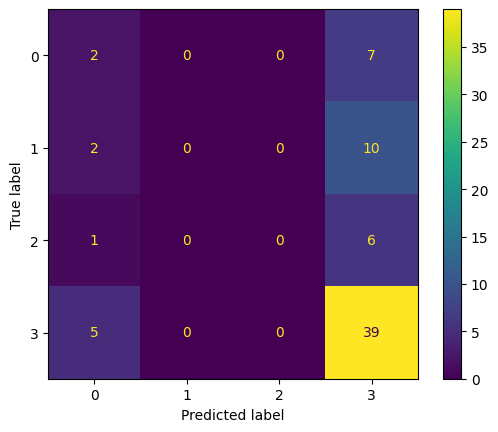

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifier_lr = LogisticRegression(random_state=42)
classifier_lr.fit(x_train, y_train)

predicted = classifier_lr.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, predicted)*100:.5} %')

cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
# TODO: discuss how we want to handle our class imbalance